<center> <h1>Pricing American Options Using Machine Learning: A Comparative Analysis with the Binomial Tree Model</h1> </center>
</br>
<center>Wanchaloem Wunkaew </center>
</br>
<center>leegarap@uw.edu </center>
</br> 
<center>University of Washington, Seattle, WA</center>

<center><h4>Abstract</h4> </center>
</br>
We proprose machine learning methods for regression including Linear Regression, Polynomial Regression, Support Vector Regressor Ridge and Lasso Regression, Random Forest Regressor, K-Nearest Neighbors Regression, Multi-layer perceptons, and Convolutional Neural Network to price American options. The methods are trained and tested on SPDR S&P 500 ETF Trust call options, from 2021 to 2022.  The result shows that Convolutional Neural Network and the Random Forest performs better than the Binomial Tree, which we use as a benchmark, in the term of testing Root Mean Squared Errors.

## Introduction

Option pricing is one of fields in financial engineering. The formalization of option pricing methods, such as the Black-Scholes equation, has greatly impactedthe field of financial economics. Among various types of options, the American Option is a distinct financial asset that grants its holder the right to buy or sell the underlying asset at any point up to, and including, its maturity date. Unlike European options, American options do not have a closed-form solution, so it requires the use of numerical methods for their pricing. The Binomial Tree and Monte Carlo simulations are two such numerical methods capable of pricing these options. One notable limitation in all option pricing methods is the unrealistic assumptions of underlying asset price models. For instance, the Geometric Brownian motion model, which is assumed in the Black-Scholes equation, does not account for heteroskedasticity and the non-normal log return. In addition, some parameters, such as $\sigma$ in the binomial tree, in these tradtional methods/models are hard to estimate.  

In this project, we employ a range of machine learning regression models, including linear regression, polynomial regression, ridge regression, lasso regression, Support Vector Regressor, Random Forest Regressor, K-Nearest Neighbor regressor, Multilayer Perceptron regressor, and Convolutional Neural Network, to price American options. We anticipate that these models may unveil relationships between inputs (such as the strike price and stock prices from 8 days prior) and the output (the option price). As such, we expect these models to either outperform or match the performance of the traditional Binomial Tree model, which we have selected as our research benchmark. Additionally, we believe that some of these models can rectify the flaws of traditional models as outlined above. 

We will divide this paper into distinct sections. In the next section, we will discuss our dataset and the Binomial Tree, which serves as our benchmark. The third section will be devoted to training machine learning models on this dataset. In the fourth section, we will summarize and discuss our findings. Lastly, in the fifth section, we will draw conclusions based on our results.

## Data Preparation and Benchmark model

We will employ the SPDR S&P 500 ETF Trust option chains from Q1 2020-Q4 2022 for our analysis. This data, which consists of more than three million options traded in markets, was downloads from <a href ="https://www.kaggle.com/datasets/kylegraupe/spy-daily-eod-options-quotes-2020-2022">Kaggle</a>.  The dataset encompasses a wealth of information, including but not restricted to, the closing option price, the closing strike price, underlying asset price, bid and ask prices, and implied volatility. Despite the fact that the dataset includes put option data, our study will only concentrate on call options.

The features incorporated in this project consist of: strike price, dividend yield, risk-free rate, the time until the option's maturity, historical volatility, and the underlying asset (adjusted closed) prices from seven days prior (including the closed price on the date that the option is traded). A majority of these features encompass parameters used to price options in the Binomial Tree model. Note that we assume no transaction fee.

The historical volatility was calculated by the standard deviation of the logarithmic return of the underlying asset over the five years preceding the date each option was observed. The risk-free rate was obtained from that Fama-French guy website. The stock prices were obtained from Yahoo Finance via yfinance as showed below, while the dividend yield was estimated from <a href ="https://ycharts.com/companies/SPY/dividend_yield"> Ycharts</a>.

Despite the dataset's size with more than three million option data entries, we will randomly sample 100,000 options for training and testing our models due to time limitation. Also, we will choose only first 10000 of the traning data for cross validation.

The output of the model is solely the corresponding call option price, denoted as "' [C_LAST]'' within the dataset.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from pandas.plotting import scatter_matrix

In [3]:
# get data from https://www.kaggle.com/datasets/kylegraupe/spy-daily-eod-options-quotes-2020-2022
df = pd.read_csv("./spy_2020_2022.csv", low_memory=False)

In [4]:
# Randomly chose 100000 samples for traning, validating, and testing
df = df.sample(100000,random_state = 42)

The columns of the option data are shown below:

In [5]:
df.columns

Index(['[QUOTE_UNIXTIME]', ' [QUOTE_READTIME]', ' [QUOTE_DATE]',
       ' [QUOTE_TIME_HOURS]', ' [UNDERLYING_LAST]', ' [EXPIRE_DATE]',
       ' [EXPIRE_UNIX]', ' [DTE]', ' [C_DELTA]', ' [C_GAMMA]', ' [C_VEGA]',
       ' [C_THETA]', ' [C_RHO]', ' [C_IV]', ' [C_VOLUME]', ' [C_LAST]',
       ' [C_SIZE]', ' [C_BID]', ' [C_ASK]', ' [STRIKE]', ' [P_BID]',
       ' [P_ASK]', ' [P_SIZE]', ' [P_LAST]', ' [P_DELTA]', ' [P_GAMMA]',
       ' [P_VEGA]', ' [P_THETA]', ' [P_RHO]', ' [P_IV]', ' [P_VOLUME]',
       ' [STRIKE_DISTANCE]', ' [STRIKE_DISTANCE_PCT]'],
      dtype='object')

In [6]:
# load option data
#df = pd.read_csv("./spy_20_21.csv")
#df = df.iloc[:,1:]
df[' [QUOTE_DATE]'] = pd.to_datetime(df[' [QUOTE_DATE]'], format = ' %Y-%m-%d')
df.set_index(" [QUOTE_DATE]", inplace = True)
df = df[[' [UNDERLYING_LAST]',' [EXPIRE_DATE]',' [C_IV]',' [C_LAST]',' [STRIKE]']]
df.columns = ['underlying_last','maturity','implied_vol','call_last', 'K']

# load stock data
#import yfinance as yf
# spy = yf.download('SPY', '2010-01-01', '2023-02-01')
# spy.to_csv('spy.csv')

spy = pd.read_csv('./spy.csv')
spy['Date'] = pd.to_datetime(spy['Date'], format = '%Y-%m-%d')
df['maturity']=pd.to_datetime(df['maturity'], format = ' %Y-%m-%d')
spy.set_index('Date', inplace = True)
# Choose only data and adjust close
spy = spy[['Adj Close']]

# Computing log return
spy = pd.DataFrame((np.log(spy['Adj Close'].shift(-1)) - np.log(spy['Adj Close'])).dropna())
spy.columns = ['ret']

Compute historical volatility $q$ by finding the std of the log return 1825 days (~5 years) in back in the past.

In [7]:
n_days_hist = 365 * 5
date_ls = list()
vol_ls = list()
spy_array = spy['ret'].to_numpy()
for i in range(n_days_hist,len(spy_array)):
    date_ls.append(spy.index[i])
    vol_ls.append(np.std(spy_array[i-n_days_hist:i+1])*np.sqrt(252))
hist_vol_df = pd.DataFrame({'Date': date_ls, "hist_vol":vol_ls})
hist_vol_df.set_index('Date', inplace = True)

In [8]:
df = df.join(hist_vol_df)

Dividend Yields are obtained and approximated from ychart website.

In [9]:
# Dividend Yield
# estimates from https://ycharts.com/companies/SPY/dividend_yield
# 2022 1.34%
# 2021 1.5
# 2020 1.7

d_yield = {2020: 1.7/100, 2021: 1.5/100, 2022: 1.34/100}
y_list = list()
for ind in df.index:
    y_list.append(d_yield[ind.year])
df['q'] = y_list

We obtain risk-free rate $r$ from <a href = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html">Kenneth French website (Fama/French 3 Factors)</a>.

We approximate the risk-free on a specific date by chooing the risk on the first day of a month corresponding to the option data.

In [10]:
# Interest rate
# Note that the csv file below was preprocessed by removing unnecessary rows and columns that broke the read_csv
mf = pd.read_csv("F-F_Research_Data_Factors.CSV").iloc[:,:2]
mf.columns = ['Date','r']
mf['r'] /= 100
mf['Date'] = pd.to_datetime(mf['Date'], format = '%Y%m')                
mf.head()

,Date,r
0,1926-07-01,0.0296
1,1926-08-01,0.0264
2,1926-09-01,0.0036
3,1926-10-01,-0.0324
4,1926-11-01,0.0253


In [11]:
mf = pd.read_csv("F-F_Research_Data_Factors.CSV")
mf = mf[["Unnamed: 0",'RF']]
mf.columns = ['Date','r']

r_years = mf['Date'].apply(lambda x: int(str(x)[:4]))
r_months =  mf['Date'].apply(lambda x: int(str(x)[4:]))

mf['year'] = r_years
mf['month'] = r_months
mf.drop(['Date'],axis = 1,inplace = True)
mf = mf[2020 <= mf['year']]
r_list = list()
for ind in tqdm(df.index):
    r_list.append(mf[(mf['year'] == ind.year) & (mf['month'] == ind.month)]['r'].to_numpy()[0])
df['r'] = r_list

100%|█████████████████████████████████| 100000/100000 [00:42<00:00, 2368.09it/s]


In [12]:
r_list = list()
r_i = 0

for ind in tqdm(df.index):
    while (mf.iloc[r_i,1] !=ind.year) or (mf.iloc[r_i,2]  != ind.month):
        r_i+=1
    r_list.append(mf.iloc[r_i,0])
df['r'] = r_list

100%|████████████████████████████████| 100000/100000 [00:05<00:00, 18277.71it/s]


Now, we compute the time until maturity $T-t$ in a year. 
This is computed by dividing a number of days between the day that the option data was observed and it maturity by 365.

We will denote this feature as $T$.


In [13]:
# Time til maturity
dd_list = list()
for days in (df['maturity']-df.index):
    dd_list.append(days.days/365)
df['T'] = dd_list

A scatter matrix which conclues the dataset are shown below:

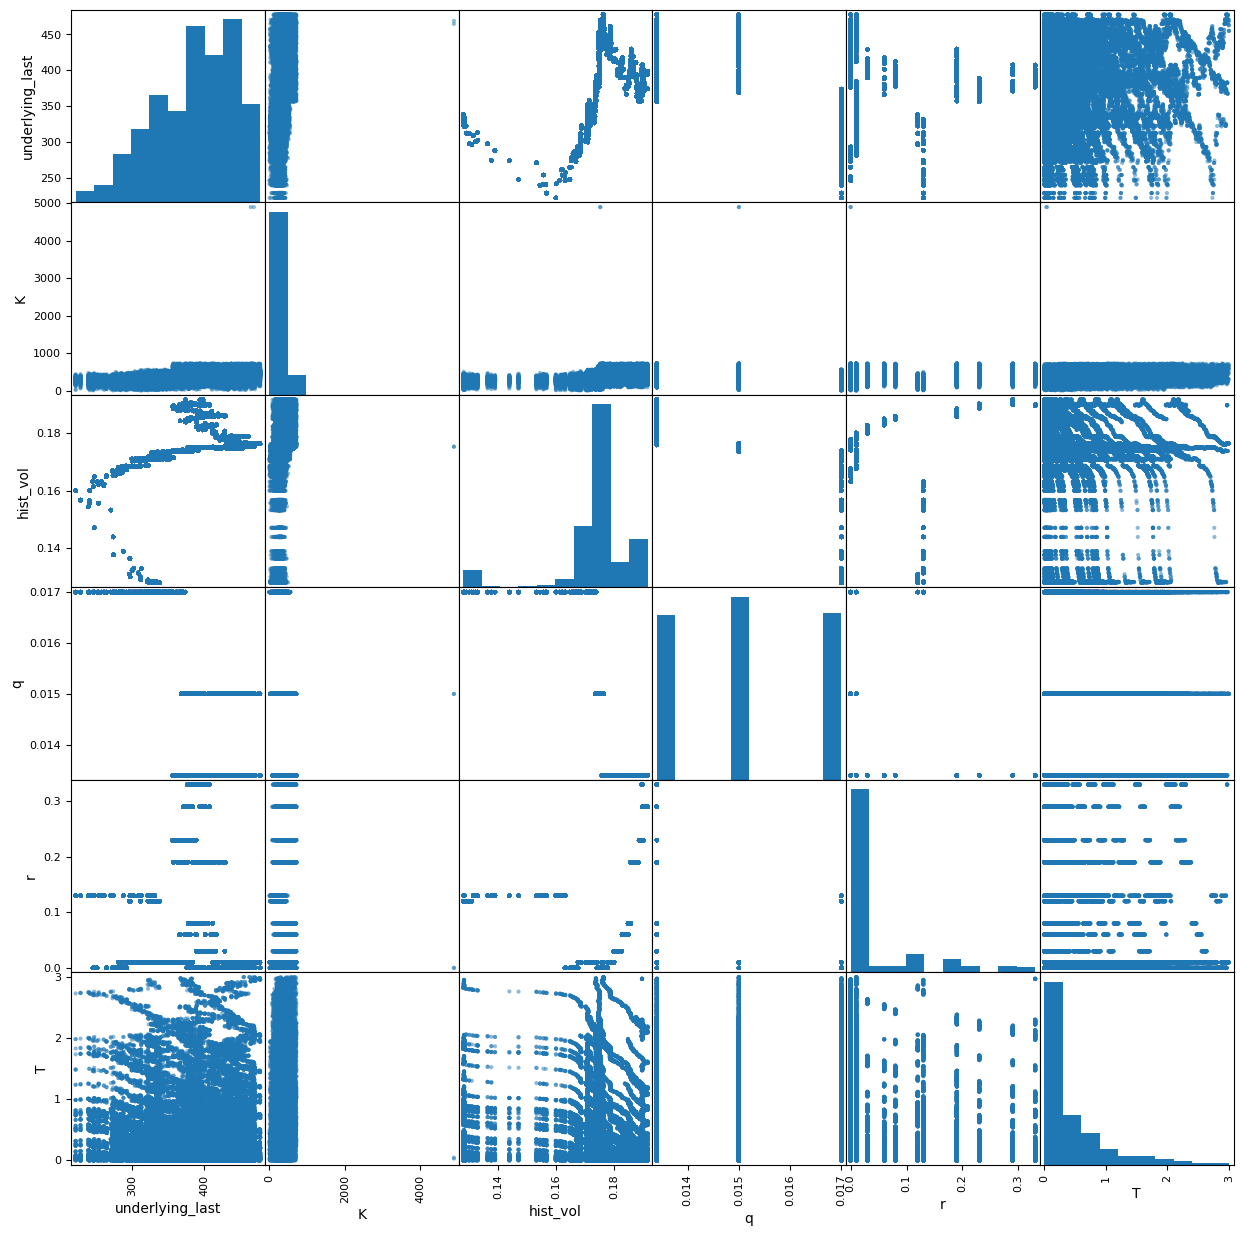

In [14]:
scatter_matrix(df[["underlying_last","call_last", "K","hist_vol","q","r","T"]],figsize = (15,15))
plt.show()

### Benchmark: American option

 In the next subsection, we will discuss the traditional method of pricing American option: Binomial Tree.
Given an initial stock, in a next step, the stock price will either go up or go down, under some pre-defined multiplicative factors: u and d. 
$$u = e^{\sigma \Delta t}$$
$$d = \frac{1}{u}$$
u and d depends solely on the volatility, so we used historical volatility to estimate this $\sigma$. 

For stock (or index) price with continuous dividend, the risk-neutral probability is computed by
$$\hat{p} = \frac{e^{(r-q) \Delta t} - d}{u -d}$$

The price for American option at node i can be computed by 
$$f_i = \max (e^{-r \Delta T} (\hat{p} f_{iu} + (1- \hat{p}) f_{id}, (s_i - K)^+)$$

where the payoff at the leaf nodes i are $ (s_i - K)^+$.

The prices of options, as observed from the market at a given time, represent the values that investors expect those options to have under the circumstances. Theorically, if we have all the necessary parameters to price an option, we can construct option prices in the market. For binomial tree, most of the parameters such as $r$, $q$,  and $S_0$ can be observed or estimated except for the $\sigma$ which is hard to estimate. One way is to construct that quantity by inversely solving the model given the option price and all other paramemters. This implied volaitlity is the volatility of the underlying asset that the market expects. When pricing option, this quantity is unknown but can be estimated. Due to volatitility smile, in many traditional model, it is hard to use the quantity in the model. Since this implied volatility can be used to reconstruct exact price of an individual option. We will not use this quantity in our model.

To estimate the volatility, werely on historical volatility of the underlying asset price. By analyzing the historical price movements of the asset, we can make an estimation of $\sigma$.

In [15]:
# American Option pricing using binomial tree
# adapted from Kevin Mooney (see reference)

def american_call_price(S0, K, sigma, t, r = 0, q = 0, N = 3 ):
    
    #delta t
    t = t / (N - 1)
    u = np.exp(sigma * np.sqrt(t))
    d = 1/u
    
    p = (np.exp((r-q) * t) - d) / (u - d)
    stock_prices = np.zeros( (N, N) )
    call_prices = np.zeros( (N, N) )

    stock_prices[0,0] = S0
    M = 0
    for i in range(1, N ):
        M = i + 1
        stock_prices[i, 0] = d * stock_prices[i-1, 0]
        for j in range(1, M ):
            stock_prices[i, j] = u * stock_prices[i - 1, j - 1]
    expiration = stock_prices[-1,:] - K
    expiration = np.exp(-q*t *(N-1))*stock_prices[-1,:] - K
    expiration.shape = (expiration.size, )
    expiration = np.where(expiration >= 0, expiration, 0)
    call_prices[-1,:] =  expiration

    # backward computing value
    for i in range(N - 2,-1,-1):
        for j in range(i + 1):
            # American Payoff
            call_prices[i,j] = np.max([np.exp(-r * t) * ((1-p) * call_prices[i+1,j] + p * call_prices[i+1,j+1]),
                                      np.max([stock_prices[i, j] - K,0])])         
    return call_prices[0,0]

We use 10-step tree for option pricing.

In [16]:
# American Option
N = 10

bm_list = list()
for i in tqdm(range(len(df))):
    current_row = df.iloc[i,:]
    
    S0 = current_row['underlying_last']
    K = current_row['K']
    sigma = current_row['hist_vol']
    r = current_row['r']
    q = current_row['q']
    T = current_row['T']
    bm_list.append(american_call_price(S0, K, sigma = sigma, t = T, r = r, q = q, N = N ))
df['bm'] = bm_list

  0%|                                    | 126/100000 [00:00<01:19, 1255.55it/s]/var/folders/6r/96ncs6hd5plcz0t1d7spstzr0000gn/T/ipykernel_47931/145875048.py:11: RuntimeWarning: invalid value encountered in double_scalars
  p = (np.exp((r-q) * t) - d) / (u - d)
100%|█████████████████████████████████| 100000/100000 [01:12<00:00, 1377.00it/s]


In [17]:
df = df[df['call_last'] != " "]
df['call_last'] = np.double(df['call_last'])
df.dropna(inplace = True)

The table for option data are shown below.
Note that we are not going to use all the columns in the table.

In [18]:
df

,underlying_last,maturity,implied_vol,call_last,K,hist_vol,q,r,T,bm
[QUOTE_DATE],,,,,,,,,,
2020-01-02,324.87,2020-09-30,0.199590,33.40,300.0,0.128190,0.0170,0.13,0.745205,47.199011
2020-01-02,324.87,2020-03-31,0.557560,100.30,215.0,0.128190,0.0170,0.13,0.243836,114.648588
2020-01-02,324.87,2020-01-27,0.130940,9.09,316.0,0.128190,0.0170,0.13,0.068493,11.905250
2020-01-02,324.87,2020-06-30,0.286710,70.85,255.0,0.128190,0.0170,0.13,0.493151,81.585331
2020-01-02,324.87,2020-01-31,0.118620,6.17,321.5,0.128190,0.0170,0.13,0.079452,8.142697
...,...,...,...,...,...,...,...,...,...,...
2022-12-30,382.44,2023-01-27,0.169750,0.38,415.0,0.189685,0.0134,0.33,0.076712,1.201606
2022-12-30,382.44,2024-01-19,0.167740,1.86,515.0,0.189685,0.0134,0.33,1.054795,27.581163
2022-12-30,382.44,2023-01-03,,0.00,332.0,0.189685,0.0134,0.33,0.010959,51.526183


The measure for quantiative models that are widely used in machine learning is the root mean square error. 
As we use the binomial model as a benchmark, we will compute the RMSE for the benchmark binomial model.

In [19]:
# MSE
from sklearn.metrics import mean_squared_error

In [20]:
np.sqrt(mean_squared_error(df['call_last'], df['bm']))

51.301668827531735

The RMSE for the benchmark model is ~51 which is high.

The statistics for the absolute error is shown below. The median error is around 3.3.

Text(0.5, 0, 'Error')

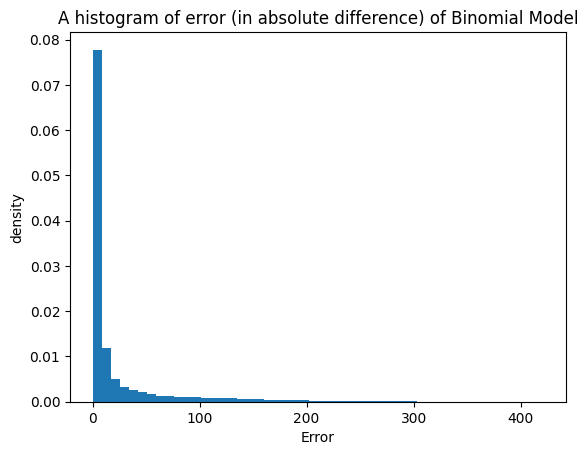

In [21]:
plt.hist(np.abs(df['bm']-df['call_last']),bins = 50, density = True)
plt.title("A histogram of error (in absolute difference) of Binomial Model")
plt.ylabel("density")
plt.xlabel("Error")

## Machine Learning Model

In addition to the (closed) underlying price, days-to-maturity, historical volatility, dividend yield, interest rate and strike price, we will also use the adjusted closed stock prices 8 days lag as inputs. 

In [22]:
Tn = 8
spy = pd.read_csv('./spy.csv')
spy['Date'] = pd.to_datetime(spy['Date'], format = '%Y-%m-%d')
spy.set_index("Date",inplace= True)
spy = spy[['Adj Close']]
spy.rename(columns={"Adj Close": "t0"}, inplace = True)
spy_use = spy[spy.index >= df.index[0]]

import warnings
warnings.filterwarnings("ignore")
for i in range(1,Tn+1):
    spy_use['t-'+str(i)] = spy['t0'].shift(i).iloc[-len(spy_use['t0']):]
df = df.join(spy_use)

In [23]:
# choose only numerical
df.drop(columns = ['maturity','implied_vol','bm','underlying_last'],inplace = True)

The first 5 rows of  final prepared dataset is shown below:

In [24]:
df.head()

,call_last,K,hist_vol,q,r,T,t0,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8
2020-01-02,33.40,300.0,0.12819,0.017,0.13,0.745205,308.517456,305.658936,304.918213,306.608582,306.684631,305.060669,305.051178,304.585846,303.256348
2020-01-02,100.30,215.0,0.12819,0.017,0.13,0.243836,308.517456,305.658936,304.918213,306.608582,306.684631,305.060669,305.051178,304.585846,303.256348
2020-01-02,9.09,316.0,0.12819,0.017,0.13,0.068493,308.517456,305.658936,304.918213,306.608582,306.684631,305.060669,305.051178,304.585846,303.256348
2020-01-02,70.85,255.0,0.12819,0.017,0.13,0.493151,308.517456,305.658936,304.918213,306.608582,306.684631,305.060669,305.051178,304.585846,303.256348
2020-01-02,6.17,321.5,0.12819,0.017,0.13,0.079452,308.517456,305.658936,304.918213,306.608582,306.684631,305.060669,305.051178,304.585846,303.256348


The original data is timestamped with the time that each option is observed. The chronological order of the data may have an effect on the model, so it is important to take the order into account. For this option pricing project, we assume that the chronological order does not have a significant effect on the models. We make an assumption that the most chornological effects are contained in the features such as historical volatility and the stock price lags.

We shuffle and split 80% for traning set, 16% for test set, 4% for validation sets.

In [25]:
from sklearn.model_selection import train_test_split
import datetime 
# We split 80% for traning set, 16% for test set, 4% for validation sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['call_last']),df['call_last'], test_size=0.2)
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size=0.2)

In [26]:
# If you believe the order affect, use the code below
#X_train = df[df.index <= datetime.datetime(2022,9,1)].copy()
#y_train = X_train[['call_last']]
#X_train = X_train.drop(columns = ['call_last'])

#X_test = df[df.index > datetime.datetime(2022,9,1)].copy()
#y_test = X_test[['call_last']]
#X_test = X_test.drop(columns = ['call_last'])

#X_valid = X_test.iloc[:1000,:]
#y_valid = y_test.iloc[:1000]

#X_test = X_test.iloc[1000:,:]
#y_test = y_test.iloc[1000:]

As we obtained the dataset, we compute the option price based on American binomial tree model on the test set in order to compare it to other models. Since a number of the test set is small, we can apply the tree for large number of steps. In this case, we use 30 steps.

### Benchmark (Binomial Tree)


In [27]:
bm_list = list()
for i in tqdm(range(len(X_test))):
    current_row = X_test.iloc[i,:]
    
    S0 = current_row['t0']
    K = current_row['K']
    sigma = current_row['hist_vol']
    r = current_row['r']
    q = current_row['q']
    T = current_row['T']
    bm_list.append(american_call_price(S0, K, sigma = sigma, t = T, r = r, q = q, N = 30 ))

100%|████████████████████████████████████| 15508/15508 [01:25<00:00, 180.46it/s]


In [28]:
np.sqrt(mean_squared_error(y_test,bm_list))

48.219430763590715

The root mean squared error for the binomial model is 48.219430763590715.

### Linear Regression

We use multiple linear regression with stdard scaled input.

In [29]:
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [30]:
lin_reg = Pipeline([("std_scaler", StandardScaler()),
                     ("LinReg", LinearRegression())])
lin_reg.fit(X_train, y_train)

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('LinReg', LinearRegression())])

The root mean squared errors for training and testing set are shown below:

In [31]:
np.sqrt(mean_squared_error(y_train,lin_reg.predict(X_train)))

38.43095625260875

In [32]:
np.sqrt(mean_squared_error(y_test,lin_reg.predict(X_test)))

37.97049534873681

The coefficients and intercept for the model are shown below:

In [33]:
lin_reg["LinReg"].coef_

array([-37.65425523,   2.524246  ,   1.51641187,  -0.54682013,
        13.45049636,   5.76041445,   3.59107429,   3.32804942,
         3.28542487,  -0.09017812,  -0.74559882,  -1.94913388,
         0.6794828 ,   9.51963281])

In [34]:
lin_reg["LinReg"].intercept_

31.72985981248147

### Polynomial Regression

For the polynomial regression, we only consider the polynomial of degree 2 with standard scaled input. We have 14 features, and the polynomial features are going to be large. 

In [35]:
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

In [36]:
PolyReg = Pipeline([("std_scaler", StandardScaler()),
          ("poly_feature", PolynomialFeatures(degree=2, include_bias=False)),
         ("LinReg",  LinearRegression())])

In [37]:
PolyReg.fit(X_train, y_train)

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('poly_feature', PolynomialFeatures(include_bias=False)),
                ('LinReg', LinearRegression())])

The root mean squared errors for training and testing set are shown below:

In [38]:
# Training Loss
np.sqrt(mean_squared_error(y_train,PolyReg.predict(X_train)))

36.17182222027887

In [39]:
# Testing Loss
np.sqrt(mean_squared_error(y_test,PolyReg.predict(X_test)))

36.06896946882215

### Ridge and Lasso Regression


For Ridge and Lasso Regression, we also find the best hyperparameters $\alpha$ using Grid Search.
We perform cross validation only on the first 10000 training data with 3-fold cross validation.

In [40]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso

In [41]:
alpha = (0.0001, 0.001, 0.01,0.1,1,10,100,500,1000,5000,10000)
ridge_reg = Pipeline([("std_scaler", StandardScaler()),
         ("ridge",  Ridge())])
parameters = {'ridge__alpha': alpha}
rr = GridSearchCV(estimator=ridge_reg,param_grid = parameters, cv = 3)
rr.fit(X_train[:10000], y_train[:10000])


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': (0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                          500, 1000, 5000, 10000)})

In [42]:
rr.best_estimator_

Pipeline(steps=[('std_scaler', StandardScaler()), ('ridge', Ridge(alpha=10))])

We found that $\alpha = 10$ is the best alpha.
We then fit this best estimator to the whole dataset.

In [43]:
best_ridge = rr.best_estimator_
best_ridge.fit(X_train, y_train)

Pipeline(steps=[('std_scaler', StandardScaler()), ('ridge', Ridge(alpha=10))])

The root mean squared errors for training and testing set are shown below:

In [44]:
# Training Loss
np.sqrt(mean_squared_error(y_train,best_ridge.predict(X_train)))

38.43095969174494

In [45]:
# Testing Loss
np.sqrt(mean_squared_error(y_test,best_ridge.predict(X_test)))

37.97019255417378

We did the same to Lasso.

In [46]:
alpha = (0.0001, 0.001, 0.01,0.1,1,10,100,500,1000,5000,10000)
lasso_reg = Pipeline([("std_scaler", StandardScaler()),
         ("lasso",  Lasso())])
parameters = {'lasso__alpha': alpha}
lr = GridSearchCV(estimator=lasso_reg, param_grid  = parameters, cv = 3)
lr.fit(X_train[:10000], y_train[:10000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': (0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                          500, 1000, 5000, 10000)})

In [47]:
lr.best_estimator_
best_lasso = lr.best_estimator_
best_lasso

Pipeline(steps=[('std_scaler', StandardScaler()), ('lasso', Lasso(alpha=0.01))])

In [48]:
best_lasso.fit(X_train, y_train)

Pipeline(steps=[('std_scaler', StandardScaler()), ('lasso', Lasso(alpha=0.01))])

The root mean squared errors for training and testing set are shown below:

In [49]:
# Training Loss
np.sqrt(mean_squared_error(y_train,best_lasso.predict(X_train)))

38.431561232353104

In [50]:
# Testing Loss
np.sqrt(mean_squared_error(y_test,best_lasso.predict(X_test)))

37.969146928057036

The best $\alpha$ is 0.01.

We can use Lasso for feature selection as it tries to minimize unimportant features coefficients to 0. 

In [51]:
lr.best_estimator_['lasso'].coef_

array([-37.64057787,   2.49377087,   1.45139028,  -0.55584586,
        13.43936913,   5.72526309,   3.68045696,   3.23670677,
         2.1807758 ,   0.        ,  -0.        ,  -0.        ,
         0.        ,   8.50465773])

In [52]:
X_train.columns

Index(['K', 'hist_vol', 'q', 'r', 'T', 't0', 't-1', 't-2', 't-3', 't-4', 't-5',
       't-6', 't-7', 't-8'],
      dtype='object')

Interestingly many of the lags of stock prices are not important.

### Support Vector Regressor

For the linear, we tune the hyperparameter C and $\epsilon$ for linear SVR. 
The other setting are the same as in previous.

In [53]:
from sklearn.svm import LinearSVR

lsvr = Pipeline([("std_scaler", StandardScaler()), 
                 ('svr',LinearSVR())])
parameters = {'svr__epsilon':(0.0001, 0.001, 0.01,0.1,1,10,100,500,1000,5000,10000),
             'svr__C': (0.0001, 0.001, 0.01,0.1,1,10,100,500,1000,5000,10000)}
lsvr_gs = GridSearchCV(estimator=lsvr,param_grid = parameters, cv = 3)
lsvr_gs.fit(X_train[:10000], y_train[:10000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('svr', LinearSVR())]),
             param_grid={'svr__C': (0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500,
                                    1000, 5000, 10000),
                         'svr__epsilon': (0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                          500, 1000, 5000, 10000)})

In [54]:
lsvr_gs.best_estimator_

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('svr', LinearSVR(C=10, epsilon=10))])

In [55]:
best_lsvr = lsvr_gs.best_estimator_

In [56]:
best_lsvr.fit(X_train, y_train)

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('svr', LinearSVR(C=10, epsilon=10))])

The root mean squared errors for training and testing set are shown below:

In [57]:
# Training Loss
np.sqrt(mean_squared_error(y_train,best_lsvr.predict(X_train)))

38.547851070665025

In [58]:
# Testing Loss
np.sqrt(mean_squared_error(y_test,best_lsvr.predict(X_test)))

38.03050061254464

The tuned c and epsilon are 10 and 10 respectively.

Now, we consider nonlinear SVR,in addtion to $\epsilon$ and $C$, we include a type of kernel as a hyperparamter. We choose between rbf and sigmoid. Note that we reduce search space for $\epsilon$ and $C$ to accelerate the computing time.

In [59]:
from sklearn.svm import SVR

In [60]:
nlsvr = Pipeline([("std_scaler", StandardScaler()), 
                 ('svr',SVR())])
parameters = {'svr__kernel':('rbf', 'sigmoid'),
              'svr__epsilon':(0.001, 0.01,0.1,1,100,5000),
             'svr__C': (0.001, 0.01,0.1,1,100,5000)
              }
nlsvr_gs = GridSearchCV(estimator=nlsvr,param_grid = parameters, cv = 3,n_jobs = -1)
nlsvr_gs.fit(X_train[:10000].to_numpy(), y_train[:10000].to_numpy().ravel())

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': (0.001, 0.01, 0.1, 1, 100, 5000),
                         'svr__epsilon': (0.001, 0.01, 0.1, 1, 100, 5000),
                         'svr__kernel': ('rbf', 'sigmoid')})

In [61]:
best_nlsvr = nlsvr_gs.best_estimator_
best_nlsvr

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('svr', SVR(C=100, epsilon=1))])

In [62]:
best_nlsvr.fit(X_train, y_train)

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('svr', SVR(C=100, epsilon=1))])

The root mean squared errors for training and testing set are shown below:

In [63]:
# Training Loss
np.sqrt(mean_squared_error(y_train,best_nlsvr.predict(X_train)))

37.808085641917536

In [64]:
# Testing Loss
np.sqrt(mean_squared_error(y_test,best_nlsvr.predict(X_test)))

37.92867379033997

### Random Forest

In [171]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

There are so many parameters, so we use random search instead of grid search. We randomly sample hyperparameters uniformly from the parameters lists for 100 samples. And we use first 10000 shuffled data entries for this tuning.

In [172]:
rf_rg = Pipeline([('std_scaler', StandardScaler()),
                     ('rf', RandomForestRegressor())])
parameters = {'rf__n_estimators': (50,100,300,400,500),
             'rf__max_depth':(None, 8,32,64,128),
             'rf__ccp_alpha':(0,0.00000001,0.00001,0.001),
             'rf__bootstrap': [True, False]}
rf_gs =RandomizedSearchCV(estimator=rf_rg,param_distributions = parameters, cv = 3,n_jobs = -1,n_iter = 100)

In [173]:
rf_gs.fit(X_train[:10000].to_numpy(), y_train[:10000].to_numpy().ravel())

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                             ('rf', RandomForestRegressor())]),
                   n_iter=160, n_jobs=-1,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__ccp_alpha': (0, 1e-08, 1e-05,
                                                          0.001),
                                        'rf__max_depth': (None, 8, 32, 64, 128),
                                        'rf__n_estimators': (50, 100, 300, 400,
                                                             500)})

In [174]:
best_rf = rf_gs.best_estimator_

In [175]:
best_rf

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('rf',
                 RandomForestRegressor(ccp_alpha=0, max_depth=8,
                                       n_estimators=400))])

In [176]:
best_rf.fit(X_train, y_train)

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('rf',
                 RandomForestRegressor(ccp_alpha=0, max_depth=8,
                                       n_estimators=400))])

The root mean squared errors for training and testing set are shown below:

In [177]:
The root mean squared errors for training and testing set are shown below:# Training Loss
np.sqrt(mean_squared_error(y_train,best_rf.predict(X_train)))

31.349066580782836

In [178]:
#Testing RMSE
np.sqrt(mean_squared_error(y_test,best_rf.predict(X_test)))

32.90546500222834

With Random Forest, we can see feature importance:

In [179]:
best_rf['rf'].feature_importances_

array([0.51617093, 0.04662939, 0.00114048, 0.00432427, 0.13790168,
       0.04360533, 0.0377016 , 0.02562464, 0.03328482, 0.01493993,
       0.05282551, 0.00782497, 0.01813578, 0.05989066])

In [180]:
X_train.columns
# Strike Price and Time to maturity seem to be the most important 

Index(['K', 'hist_vol', 'q', 'r', 'T', 't0', 't-1', 't-2', 't-3', 't-4', 't-5',
       't-6', 't-7', 't-8'],
      dtype='object')

The best hyperparamters are ccp_alpha=0, max_depth=8, n_estimators=400, and bootstrap = False.

### K-Nearest Neighbors

In this model, we only tune a number of neighbors as a hyperparameter.

In [127]:
from sklearn.neighbors import KNeighborsRegressor

In [143]:
knn_rg = Pipeline([('std_scaler', StandardScaler()),
                  ('knn',KNeighborsRegressor())])
parameters = {'knn__n_neighbors': np.arange(5,100,5)}

In [156]:
knn_gs = GridSearchCV(estimator=knn_rg,param_grid = parameters, cv = 3,n_jobs = -1)
knn_gs.fit(X_train[:10000], y_train[:10000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])})

In [157]:
best_knn = knn_gs.best_estimator_
best_knn

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('knn', KNeighborsRegressor(n_neighbors=15))])

In [184]:
best_knn.fit(X_train, y_train)

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('knn', KNeighborsRegressor(n_neighbors=15))])

The root mean squared errors for training and testing set are shown below:

In [185]:
np.sqrt(mean_squared_error(y_train,best_knn.predict(X_train)))

31.92967572127278

In [186]:
np.sqrt(mean_squared_error(y_test,best_knn.predict(X_test)))

32.912277382176526

The best number of the neigbors is 15.

### Multi-layer perceptron

For neutral network, we make experiments on three models, which are multilayer perceptron (with dropout and normalization, with relu as an activation function for the hidden layers and identity for the output layer), multilayer perceptron with tuned hyperparameters, and Convolutional Neural network.

In [82]:
from tensorflow.keras import Sequential, layers
import tensorflow as tf

2023-05-31 17:15:39.270253: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [83]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(30, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(30, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation= None)
])

In [84]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train, y_train, epochs=1000,
                    validation_data=(X_valid, y_valid),callbacks=[callback])

Epoch 1/1000
2424/2424 [==============================] - 8s 2ms/step - loss: 2348.1985 - val_loss: 1538.4142
Epoch 2/1000
2424/2424 [==============================] - 4s 2ms/step - loss: 1858.8630 - val_loss: 1519.5778
Epoch 3/1000
2424/2424 [==============================] - 4s 2ms/step - loss: 1826.4266 - val_loss: 1481.3267
Epoch 4/1000
2424/2424 [==============================] - 4s 2ms/step - loss: 1821.6594 - val_loss: 1479.6355
Epoch 5/1000
2424/2424 [==============================] - 4s 2ms/step - loss: 1815.7463 - val_loss: 1452.8606
Epoch 6/1000
2424/2424 [==============================] - 4s 2ms/step - loss: 1803.6791 - val_loss: 1457.6923
Epoch 7/1000
2424/2424 [==============================] - 4s 2ms/step - loss: 1796.4032 - val_loss: 1453.8772
Epoch 8/1000
2424/2424 [==============================] - 4s 2ms/step - loss: 1796.3320 - val_loss: 1446.6718
Epoch 9/1000
2424/2424 [==============================] - 4s 2ms/step - loss: 1788.8895 - val_loss: 1437.1597
Epoch 10/1

Epoch 75/1000
2424/2424 [==============================] - 4s 2ms/step - loss: 1711.6993 - val_loss: 1435.7582
Epoch 76/1000
2424/2424 [==============================] - 4s 2ms/step - loss: 1717.6664 - val_loss: 1458.3612
Epoch 77/1000
2424/2424 [==============================] - 4s 2ms/step - loss: 1722.2780 - val_loss: 1415.3036
Epoch 78/1000
2424/2424 [==============================] - 4s 2ms/step - loss: 1716.8831 - val_loss: 1432.3440
Epoch 79/1000
2424/2424 [==============================] - 4s 2ms/step - loss: 1728.6538 - val_loss: 1426.1598
Epoch 80/1000
2424/2424 [==============================] - 4s 2ms/step - loss: 1713.8955 - val_loss: 1415.4485
Epoch 81/1000
2424/2424 [==============================] - 4s 2ms/step - loss: 1717.9971 - val_loss: 1428.0583
Epoch 82/1000
2424/2424 [==============================] - 4s 2ms/step - loss: 1729.1248 - val_loss: 1423.9069
Epoch 83/1000
2424/2424 [==============================] - 4s 2ms/step - loss: 1726.0729 - val_loss: 1415.2335
E

In [85]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 14)               56        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 30)                450       
                                                                 
 batch_normalization_1 (Batc  (None, 30)               120       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 30)                9

The learning curve is shown below:

Text(0.5, 0, 'Epoch')

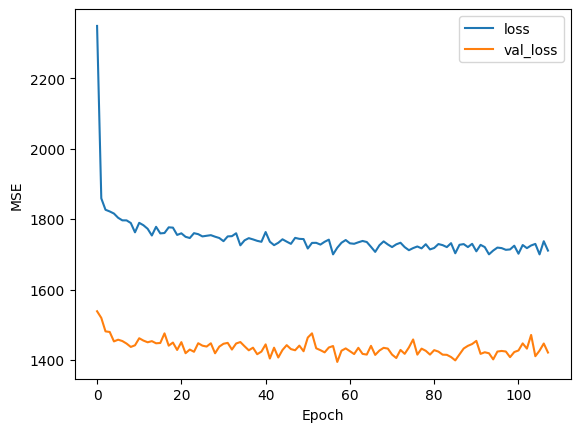

In [86]:
plt.plot(history.history['loss'],label = "loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Epoch")

The root mean squared errors for training and testing set are shown below:

In [87]:
#trainig RMSE
np.sqrt(mean_squared_error(y_train,model.predict(X_train)))

2424/2424 [==============================] - 2s 714us/step


36.21230441027238

In [88]:
#testing RMSE
np.sqrt(mean_squared_error(y_test,model.predict(X_test)))

485/485 [==============================] - 0s 675us/step


35.71456726735933

The model seems to be underfitting.

### Hyperparamter-tuned MLP

We use keras tuner library to tune the hyperparameters of the network. The hyperparameter space is shown below.

In [94]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=8)
    n_neurons = hp.Int("n_neurons", min_value=1, max_value=100)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    l2_rate = hp.Float("l2", min_value=1e-4, max_value=100,
                             sampling="log")
    optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Normalization(input_shape=X_train.shape[1:]))
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu",kernel_initializer="he_normal",kernel_regularizer=tf.keras.regularizers.l2(l2_rate)))
    model.add(tf.keras.layers.Dense(1,kernel_regularizer=tf.keras.regularizers.l2(l2_rate)))
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [95]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_loss", max_trials=20, seed=42)
random_search_tuner.search(X_train[:5000], y_train[:5000], epochs=150,
                           validation_data=(X_valid, y_valid))


Trial 20 Complete [00h 00m 53s]
val_loss: 1461.2305908203125

Best val_loss So Far: 1451.614013671875
Total elapsed time: 00h 15m 31s
INFO:tensorflow:Oracle triggered exit


In [96]:
random_search_tuner.get_best_hyperparameters()[0].values

{'n_hidden': 7,
 'n_neurons': 15,
 'learning_rate': 0.0006237028864858578,
 'l2': 0.0003065801184974072}

The best hyperparameters we found are 7 hidden layers with 15 neurons each, 0.0006237028864858578 learning rate, and l2 = 0.0003065801184974072 for the l2 regularization.

In [97]:
best_nn = random_search_tuner.get_best_models()[0]

In [98]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100,restore_best_weights=True)
history_best_nn = best_nn.fit(X_train, y_train, epochs=1000,
                    validation_data=(X_valid, y_valid),callbacks=[callback])

Epoch 1/1000
2424/2424 [==============================] - 6s 1ms/step - loss: 1364.6182 - val_loss: 1498.1863
Epoch 2/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1363.1213 - val_loss: 1462.6725
Epoch 3/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1354.9094 - val_loss: 1493.1799
Epoch 4/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1349.7559 - val_loss: 1452.7467
Epoch 5/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1347.2516 - val_loss: 1499.4685
Epoch 6/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1341.6652 - val_loss: 1437.6245
Epoch 7/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1340.0056 - val_loss: 1423.4025
Epoch 8/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1340.5402 - val_loss: 1513.4679
Epoch 9/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1340.7520 - val_loss: 1569.9033
Epoch 10/1

Epoch 75/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1294.1788 - val_loss: 1419.4735
Epoch 76/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1288.8263 - val_loss: 1387.4668
Epoch 77/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1291.7236 - val_loss: 1449.1144
Epoch 78/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1293.4061 - val_loss: 1362.5378
Epoch 79/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1289.6440 - val_loss: 1497.2910
Epoch 80/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1291.5959 - val_loss: 1411.2170
Epoch 81/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1289.1887 - val_loss: 1416.5708
Epoch 82/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1285.9327 - val_loss: 1476.6334
Epoch 83/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1287.9426 - val_loss: 1393.4445
E

2424/2424 [==============================] - 3s 1ms/step - loss: 1266.4158 - val_loss: 1366.8619
Epoch 222/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1264.4547 - val_loss: 1352.4104
Epoch 223/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1264.1013 - val_loss: 1385.2520
Epoch 224/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1263.7904 - val_loss: 1349.5062
Epoch 225/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1260.7881 - val_loss: 1360.7559
Epoch 226/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1266.1720 - val_loss: 1353.9856
Epoch 227/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1266.6436 - val_loss: 1381.2483
Epoch 228/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1264.5753 - val_loss: 1397.2802
Epoch 229/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1259.1239 - val_loss: 1353.7999
Epoch 2

2424/2424 [==============================] - 3s 1ms/step - loss: 1250.7550 - val_loss: 1358.7091
Epoch 368/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1241.2279 - val_loss: 1357.4357
Epoch 369/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1248.7603 - val_loss: 1374.3285
Epoch 370/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1249.3293 - val_loss: 1336.9712
Epoch 371/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1241.3035 - val_loss: 1331.5042
Epoch 372/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1247.4591 - val_loss: 1325.9847
Epoch 373/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1251.0770 - val_loss: 1375.1504
Epoch 374/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1246.7225 - val_loss: 1382.1328
Epoch 375/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1256.0936 - val_loss: 1376.3654
Epoch 3

2424/2424 [==============================] - 3s 1ms/step - loss: 1235.8590 - val_loss: 1373.3347
Epoch 514/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1231.0608 - val_loss: 1380.6416
Epoch 515/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1234.1034 - val_loss: 1379.2932
Epoch 516/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1237.7863 - val_loss: 1403.0165
Epoch 517/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1235.5370 - val_loss: 1434.4629
Epoch 518/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1248.6022 - val_loss: 1322.6416
Epoch 519/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1236.1560 - val_loss: 1361.2306
Epoch 520/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1239.9530 - val_loss: 1336.1486
Epoch 521/1000
2424/2424 [==============================] - 3s 1ms/step - loss: 1234.6815 - val_loss: 1371.8948
Epoch 5

The root mean squared errors for training and testing set are shown below:

In [99]:
# Traing RMSE
np.sqrt(mean_squared_error(y_train,best_nn.predict(X_train)))

2424/2424 [==============================] - 2s 597us/step


34.78459569413211

In [100]:
# Testing RMSE
np.sqrt(mean_squared_error(y_test,best_nn.predict(X_test)))

485/485 [==============================] - 0s 612us/step


34.821059741172114

The learning curve is shown below.

Text(0.5, 0, 'Epoch')

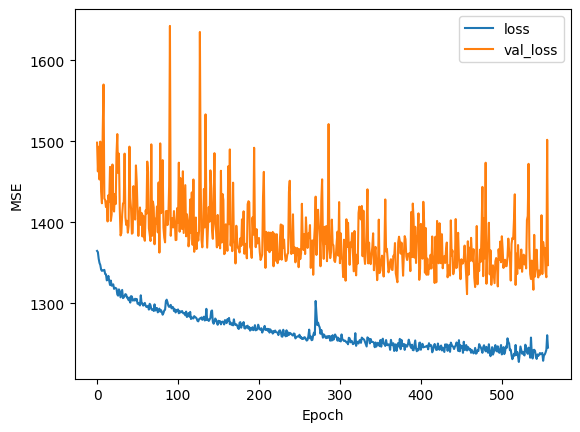

In [101]:
plt.plot(history_best_nn.history['loss'],label = "loss")
plt.plot(history_best_nn.history['val_loss'], label = "val_loss")
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Epoch")

### Convolutional Neural Network (CNN)

The structure of the convolutional network is shown below.

In [102]:
model_conv = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32,2,activation = 'relu',input_shape = (14,1,), kernel_initializer="he_normal",padding = 'same'),
    tf.keras.layers.Conv1D(32,3,activation = 'relu', kernel_initializer="he_normal",padding = 'same'),
    tf.keras.layers.Conv1D(32,3,activation = 'relu', kernel_initializer="he_normal"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(32, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation= None)
])



In [103]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True)
model_conv.compile(loss="mse", optimizer="nadam")
history_cov = model_conv.fit(X_train, y_train, epochs=1000,
                    validation_data=(X_valid, y_valid),callbacks=[callback])

Epoch 1/1000
2424/2424 [==============================] - 7s 2ms/step - loss: 1632.2096 - val_loss: 1460.4231
Epoch 2/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1373.3662 - val_loss: 1505.1824
Epoch 3/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1366.6722 - val_loss: 1474.0969
Epoch 4/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1346.9469 - val_loss: 1475.6388
Epoch 5/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1334.1947 - val_loss: 1547.0897
Epoch 6/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1323.7288 - val_loss: 1439.5723
Epoch 7/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1310.3964 - val_loss: 1432.5355
Epoch 8/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1294.4939 - val_loss: 1449.5792
Epoch 9/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1290.2340 - val_loss: 1363.4564
Epoch 10/1

Epoch 75/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1150.9237 - val_loss: 1256.0906
Epoch 76/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1158.6924 - val_loss: 1219.9215
Epoch 77/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1151.5303 - val_loss: 1210.6943
Epoch 78/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1156.8185 - val_loss: 1243.4762
Epoch 79/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1149.7745 - val_loss: 1240.2955
Epoch 80/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1148.9011 - val_loss: 1251.2832
Epoch 81/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1148.1597 - val_loss: 1188.1097
Epoch 82/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1145.2150 - val_loss: 1197.4039
Epoch 83/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1139.6521 - val_loss: 1259.9893
E

2424/2424 [==============================] - 5s 2ms/step - loss: 1015.9850 - val_loss: 1246.4061
Epoch 222/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1024.9508 - val_loss: 1166.5314
Epoch 223/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1021.7601 - val_loss: 1132.3287
Epoch 224/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1022.7983 - val_loss: 1165.6740
Epoch 225/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1018.3124 - val_loss: 1170.6283
Epoch 226/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1017.9795 - val_loss: 1195.0621
Epoch 227/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1018.9117 - val_loss: 1195.9948
Epoch 228/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1011.5366 - val_loss: 1160.3621
Epoch 229/1000
2424/2424 [==============================] - 5s 2ms/step - loss: 1020.4540 - val_loss: 1142.8944
Epoch 2

In [104]:
model_conv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 14, 32)            96        
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 32)            3104      
                                                                 
 conv1d_2 (Conv1D)           (None, 12, 32)            3104      
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               49280     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)               

The learning curve is shown below.

Text(0.5, 0, 'Epoch')

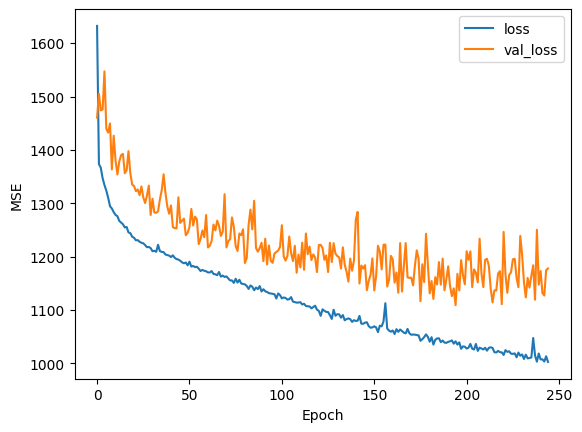

In [107]:
plt.plot(history_cov.history['loss'],label = "loss")
plt.plot(history_cov.history['val_loss'], label = "val_loss")
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Epoch")

The root mean squared errors for training and testing set are shown below:

In [105]:
# Training RMSE
np.sqrt(mean_squared_error(y_train,model_conv.predict(X_train)))

2424/2424 [==============================] - 2s 920us/step


31.66131974960281

In [106]:
# Testing RMSE
np.sqrt(mean_squared_error(y_test,model_conv.predict(X_test)))

485/485 [==============================] - 0s 814us/step


32.372653521773714

## Result

The Root Mean Square Error for each machine learning models are shown below, together with the chosen hyperparamters.

In [190]:
res = pd.DataFrame({"Model": ["Binomial Tree",'Linear Regression',"Polynomial Regression","Ridge Regression","Lasso Regression","Linear SVR","Nonlinear SVR","Random Forest","KNN","Neural Network", "Neural Network (tuned)", " Convolutional Neutral Network"],
                   "RMSE(training)":[None,
38.43095625260875,
36.17182222027887,
38.43095969174494,
38.431561232353104,
38.547851070665025,
37.808085641917536,
31.349066580782836,
31.92967572127278,
36.21230441027238,
34.78459569413211,
31.66131974960281
],
                "RMSE(testing)":
                   [48.219430763590715,
                    37.97049534873681,
36.06896946882215,
37.97019255417378,
37.969146928057036,
38.03050061254464,
37.92867379033997,
32.90546500222834,
32.912277382176526,
35.71456726735933,
34.821059741172114,
32.372653521773714
],
"Hyperparameters" :
        ["29 steps","",
"degree = 2",
"alpha = 10",
"alpha = 0.01",
"C=10, epsilon=10",
"C=100, epsilon=1",
"ccp_alpha=0, max_depth=8, n_estimators=400, bootstrap = False",
         "neighbors = 15",
        "consider model summary above",
        "consider model summary above",
        "consider model summary above"]    
                   })
res

,Model,RMSE(training),RMSE(testing),Hyperparameters
0,Binomial Tree,NaN,48.219431,29 steps
1,Linear Regression,38.430956,37.970495,
2,Polynomial Regression,36.171822,36.068969,degree = 2
3,Ridge Regression,38.430960,37.970193,alpha = 10
4,Lasso Regression,38.431561,37.969147,alpha = 0.01
5,Linear SVR,38.547851,38.030501,"C=10, epsilon=10"
6,Nonlinear SVR,37.808086,37.928674,"C=100, epsilon=1"
7,Random Forest,31.349067,32.905465,"ccp_alpha=0, max_depth=8, n_estimators=400, bo..."
8,KNN,31.929676,32.912277,neighbors = 25
9,Neural Network,36.212304,35.714567,consider model summary above


Consider the RMSE for the testing set, the lower RMSE, the more accurate the model to compute option price. By this sole metric, all the machine learning model we used in this project performs better than the binomial tree.
By ranking the models by this value, we have that the Convolutional Neural Network performs the best, the random forest is the second best, and the K-Nearest Neighbors is the third. 

The statistics for the absolute error for the best three models and the binomial tree are shown below.

In [216]:
res_error = pd.concat([pd.DataFrame({"binomial abs_error": np.abs(np.array(bm_list) -y_test.to_numpy().flatten())}).describe(),
                        np.abs(model_conv.predict(X_test).ravel() - y_test).describe(),
          np.abs((best_rf.predict(X_test).ravel()-y_test)).describe(),
                       np.abs(best_knn.predict(X_test).ravel() - y_test ).describe(),],axis = 1)


res_error.columns = ["Binomial Tree Absolute Error","CNN Absolute Error","Random Forest Absolute Error","KNN Absolute Error"]
res_error

485/485 [==============================] - 0s 908us/step


,Binomial Tree Absolute Error,CNN Absolute Error,Random Forest Absolute Error,KNN Absolute Error
count,15508.000000,15508.000000,15508.000000,15508.000000
mean,22.192882,16.865260,17.565473,17.039533
std,42.810135,27.633330,27.825774,28.158896
min,0.000000,0.000103,0.000018,0.000000
25%,0.749303,0.927289,1.313031,0.710667
50%,7.469478,4.053897,5.481253,4.335000
75%,17.896939,22.537766,22.226330,21.908333
max,369.079773,350.456573,338.299600,341.098000


By considering the median for the absolute errors for each model, we can see that those of the machine learing models are smaller than that from the benchmark model. This implies that for at least half of the dataset, the absolute error from the machine learing models are smaller than that from the benchmark. 
However, if we consider other quantitle, we can see that there are not much different. But for most part, the machine learning models have smaller errors.

### Stock Price versus Predicted Call Price

By the RMSE on the testing set, we choose the CNN to be the best model. 
We visualize $C_0$ as a function of strike price $K$ and the stock price $S_0$.

In [218]:
res_pt = pd.concat([X_test[['t0']].set_index(np.arange(0,len(X_test))).rename(columns = {"t0":"stock price"}),
                    X_test[['K']].set_index(np.arange(0,len(X_test))).rename(columns = {"K":"K"}),
            pd.DataFrame({"Call Price from the dataset": y_test.to_numpy().ravel()}),
           pd.DataFrame({"Call Price from Binomial Tree": bm_list}),
           pd.DataFrame({"Call Price from CNN": model_conv.predict(X_test).ravel()}),
          pd.DataFrame({"lower bound": 
              [np.max([lb,0]) for lb in X_test['t0'] - X_test['K']*np.exp(-X_test['r'] *X_test['T'])]})], axis = 1)

485/485 [==============================] - 1s 1ms/step


In [220]:
# Percentage of call price greater than 120
np.sum(y_test.to_numpy() >= 120)/len(y_test)

0.06970595821511479

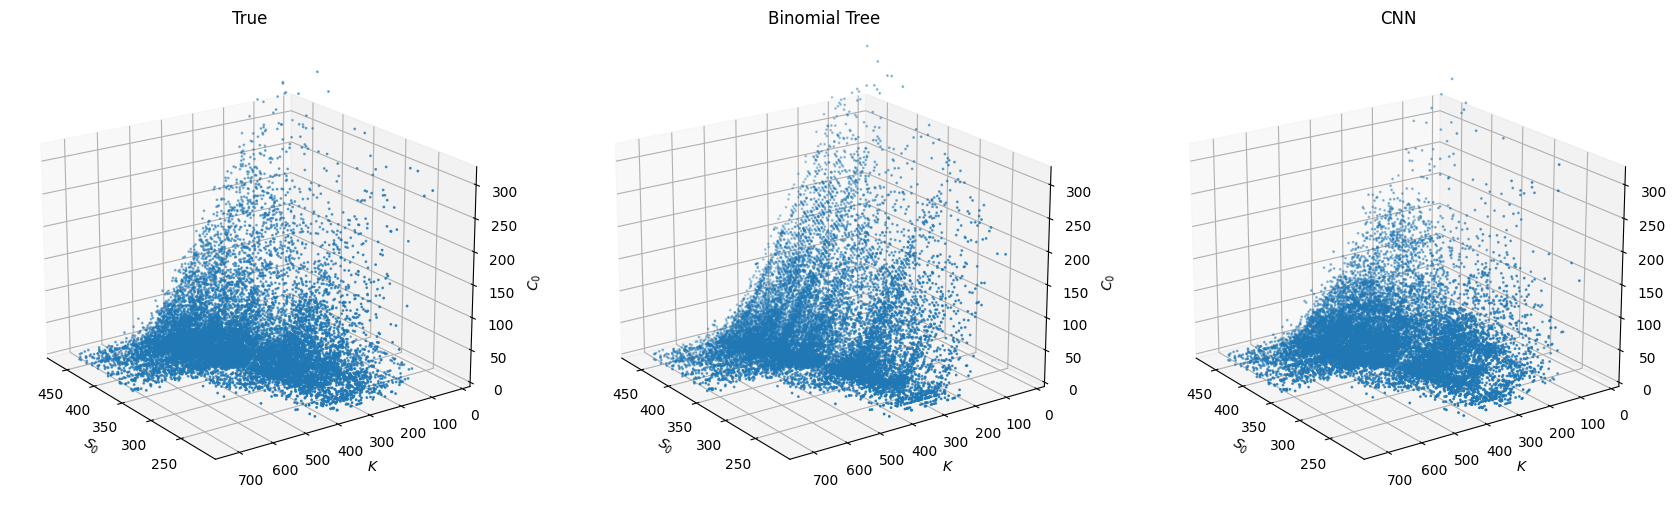

In [228]:
fig,axes = plt.subplots(1,3, figsize = (21,8),subplot_kw={'projection': '3d'})
axes[0].scatter(res_pt['stock price'], res_pt["K"],res_pt["Call Price from the dataset"], s= 1)
axes[0].set_xlabel("$S_0$")
axes[0].set_ylabel("$K$")
axes[0].set_zlabel("$C_0$")
axes[0].view_init(elev=20., azim=145, roll=0)
axes[0].set_title("True")
axes[0].set_zlim([0,320])

axes[1].scatter(res_pt['stock price'], res_pt["K"],res_pt["Call Price from Binomial Tree"], s= 1)
axes[1].set_xlabel("$S_0$")
axes[1].set_ylabel("$K$")
axes[1].set_zlabel("$C_0 $")
axes[1].view_init(elev=20., azim=145, roll=0)
axes[1].set_title("Binomial Tree")
axes[1].set_zlim([0,320])


axes[2].scatter(res_pt['stock price'], res_pt["K"],res_pt["Call Price from CNN"], s= 1)
axes[2].set_xlabel("$S_0$")
axes[2].set_ylabel("$K$")
axes[2].set_zlabel("$C_0 $")
axes[2].set_title("CNN")
axes[2].view_init(elev=20., azim=145, roll=0)
axes[2].set_zlim([0,320])


plt.show()

By considering only two factors, $S_0$ and $K$, we can see some paterrns in the corresponding option price. All the three plots look similar, indicating the accuracy of the binomial tree and the Convolutional Neural Network to price options. However, in the convolutional neural network, we can see that the call prices are dense around the small values similar to the actual price, however it did not well capture high call prices. For the benchmark, the prices are more sparse compared to both actual price and the CNN.

Now, we visualize an option price as a function of stock price, fixing other variable.

We fix other variable by choosing those variables from the dataset.

Then, we compare an option price as a function of $S_0$ from Binomial Tree and the best model. 

Remark that, the machine learning models require additional parameters which are stock prices 8 days in the past. We cannot fix these stock prices; otherwise, the underlying price is unrealistic (eg. stock price at 0 is 500, while those at -1, -2, are around 200).

For each $S_0$, we find relevant $S_{-1}, S_{-2}$, ..., in the dataset. 

We also compute a upperbound and lowerbound as shown below.


The upper and lower bound for American option (for non-dividend) can be computed by
$$\max(S_t - K e^{-r (T-t)},0)\leq C_t \leq S_t$$

In [398]:
# Choose only S_0_x (rounded) that we use to train model
S_0_x = np.unique(np.round(spy_use['t0']) )
binomial_vs_s0 = [american_call_price(xs0, sample_fixed['K'][0], sigma = sample_fixed['hist_vol'][0], t = sample_fixed['T'][0], r = sample_fixed['r'][0], q = sample_fixed['q'][0], N = 30 ) for xs0 in S_0_x ]
spy_extended = spy_use.copy()
spy_extended['round_t0'] = np.round(spy_use['t0']) 
s0_dataset = []
for xs0 in S_0_x:
    s0_dataset.append(np.concatenate([sample_fixed.drop(columns = ["call_last",'t0']).to_numpy()[0,:5], spy_extended[spy_extended['round_t0'] == xs0].sample(1).iloc[0,:9].ravel()]))
s0_dataset = np.array(s0_dataset)
cnn_vs_s0 = model_conv.predict(s0_dataset).ravel()

7/7 [==============================] - 0s 1ms/step


In [399]:
max_bound = S_0_x
min_bound = [np.max([xs0 - sample_fixed['K'][0] * np.exp(-sample_fixed['r'][0]*sample_fixed['T'][0]),0]) for xs0 in S_0_x ]

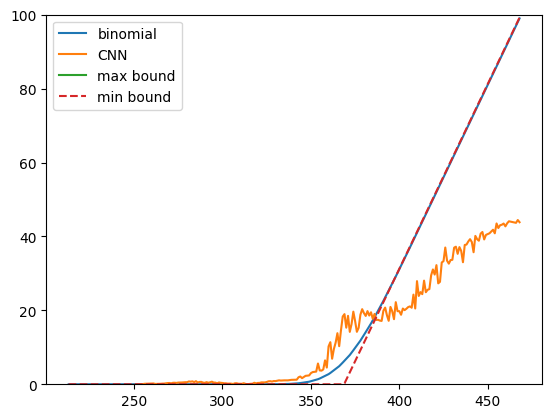

In [400]:
plt.plot(S_0_x ,binomial_vs_s0,label = 'binomial')
plt.plot(S_0_x ,cnn_vs_s0,label = 'CNN')
plt.plot(S_0_x ,max_bound,label = 'max bound')
plt.plot(S_0_x ,min_bound,label = 'min bound',ls = 'dashed')
plt.ylim([0,100])
plt.legend()

The plot aligns with the previous plot, suggesting consistency. However, it appears that the CNN model does not accurately capture the high call prices. The generated call prices are observed to be outside the lower bound for high underlying price, creating the potential for arbitrage opportunities. Therefore, it is crucial to exercise caution and conduct a thorough examination of the model before implementing it. Additionally, fine-tuning or training the CNN model with a larger and more comprehensive dataset could potentially improve its performance and yield a better model.

## Conclusion


In this project, we have utilized machine learning models to price American options based on the SPY dataset. Our findings indicate that all of the machine learning models outperform the traditional binomial model for both the testing and training sets. Among these models, CNN, random forest, and KNN show promise, as their testing and training losses are relatively low.

However, it is worth noting that even though CNN performs the best overall, it struggles with accurately computing high call prices. Therefore, further tuning and dataset preparation might be necessary to enhance its performance in this regard.

In conclusion, machine learning models demonstrate the ability to capture the relationship between financial information and option pricing. Through the utilization of the RMSE metric, these models outperform the traditional benchmark model. Nonetheless, additional tunin

## Acknoledgement

Thanks all people who gathered the data and publicly publish them online. Thank you Dr. Kevin Lu for giving suggestions on American option pricing models.

## References

Culkin, Robert, and Sanjiv R. Das. Machine Learning in Finance: The Case of Deep Learning for Option Pricing, 2 Aug. 2017, srdas.github.io/Papers/BlackScholesNN.pdf. 

French, Kenneth R. Kenneth R. French - Data Library, mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html. Accessed 3 June 2023. 

Graupe, Kyle. “$spy Option Chains - Q1 2020 - Q4 2022.” Kaggle, 14 Mar. 2023,
www.kaggle.com/datasets/kylegraupe/spy-daily-eod-options-quotes-2020-2022. 

Lu, Kevin. “Machine Learning for Finance Lectures.” CFRM 421:Machine Learning for Finance . Seattle, The University of Washington. 

Lu, Kevin. “Introduction to Financial Markets Lectures.” CFRM 415: Introduction to Financial Markets. Seattle, The University of Washington. 

Mooney, Kevin, director. Implementing the Binomial Option Pricing Model in Python, YouTube, 15 Feb. 2021, https://www.youtube.com/watch?v=d7wa16RNRCI. Accessed 5 June 2023. 

SPY Dividend Yield, ycharts.com/companies/SPY/dividend_yield. Accessed 3 June 2023. 